# Compute LSA features

In [1]:
import polars as pl

try:
    df = pl.read_csv('/mnt/data01/data/TreeSearch/data/from_organizers/train.csv')
except:
    df = pl.read_csv('data/from_organizers/train.csv')

df = df.to_pandas()

In [2]:
all_lud_rules = df['LudRules'].to_list()
unique_lud_rules = list(set(all_lud_rules))
print(f'Unique LudRules count: {len(unique_lud_rules)}')

all_english_rules = df['EnglishRules'].to_list()
unique_english_rules = list(set(all_english_rules))
print(f'Unique EnglishRules count: {len(unique_english_rules)}')

Unique LudRules count: 1373
Unique EnglishRules count: 1328


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

lud_vectorizer = TfidfVectorizer()
tfidf_lud_rules = lud_vectorizer.fit_transform(unique_lud_rules)

n_components = 100
lud_lsa = make_pipeline(TruncatedSVD(n_components), Normalizer(copy=False))
lud_lsa_features = lud_lsa.fit_transform(tfidf_lud_rules)

print('TF-IDF shape:', tfidf_lud_rules.shape)
print('LSA shape:', lud_lsa_features.shape)
print('LSA explained variance:', lud_lsa.named_steps['truncatedsvd'].explained_variance_ratio_.sum())

TF-IDF shape: (1373, 4032)
LSA shape: (1373, 100)
LSA explained variance: 0.7697208957313506


In [4]:
english_vectorizer = TfidfVectorizer()
tfidf_english_rules = english_vectorizer.fit_transform(unique_english_rules)

n_components = 100
english_lsa = make_pipeline(TruncatedSVD(n_components), Normalizer(copy=False))
english_lsa_features = english_lsa.fit_transform(tfidf_english_rules)

print('TF-IDF shape:', tfidf_english_rules.shape)
print('LSA shape:', english_lsa_features.shape)
print('LSA explained variance:', english_lsa.named_steps['truncatedsvd'].explained_variance_ratio_.sum())

TF-IDF shape: (1328, 3659)
LSA shape: (1328, 100)
LSA explained variance: 0.5831654568580832


# Load agent features

In [5]:
from ColumnNames import AGENT_COLS

df = pl.DataFrame(df)

for col in AGENT_COLS:
    df = df.with_columns(pl.col(col).str.split(by="-").list.to_struct(fields=lambda idx: f"{col}_{idx}")).unnest(col).drop(f"{col}_0")
df = df.with_columns([pl.col(col).cast(pl.Categorical) for col in df.columns if col[:6] in AGENT_COLS])

df = df.to_pandas()

split_agent_col_names = [col for col in df.columns if col[:6] in AGENT_COLS]
agent_features = df[split_agent_col_names].to_numpy()

In [6]:
split_agent_col_names

['agent1_1',
 'agent1_2',
 'agent1_3',
 'agent1_4',
 'agent2_1',
 'agent2_2',
 'agent2_3',
 'agent2_4']

# Load parallel rule features & targets

In [7]:
lud_rules_to_features = dict(zip(unique_lud_rules, lud_lsa_features))
english_rules_to_features = dict(zip(unique_english_rules, english_lsa_features))

all_lud_features = []
all_english_features = []
for lud_rule, english_rule in zip(all_lud_rules, all_english_rules):
    all_lud_features.append(lud_rules_to_features[lud_rule])
    all_english_features.append(english_rules_to_features[english_rule])

In [8]:
targets = df['utility_agent1'].to_numpy()

# Try encoding rule clusters as categorical variables

In [9]:
import numpy as np

np.array(all_lud_features).shape

(233234, 100)

In [62]:
unique_lud_features = np.unique(all_lud_features, axis=0)
unique_lud_features.shape

(1314, 100)

In [74]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

clustering_algo = KMeans(n_clusters=100, random_state=0).fit(unique_lud_features)
# clustering_algo = DBSCAN(eps=0.4, n_jobs = -1).fit(unique_lud_features)
# clustering_algo = AgglomerativeClustering().fit(unique_lud_features)

print(np.bincount(clustering_algo.labels_))
print(np.mean(np.bincount(clustering_algo.labels_)))

[ 7  9  4 41 37 18 12  7  9 16  4  7 21 11 31 27 16 39 14 54 26  7  5 20
 10 13 34  5 24 16  5 11  3 25  8 37  9 14 11  5 35  5 24 12 16  5  6 31
  7  3  4 10 11  9  8  6 12  6  6 11 20  7 14 27 21  6  9  5 44  4  7 17
  5 18 13  6  3  5  4  6  4  5 13 12  9  3  9  4  4  5  6  5  9  6 14  8
 13 24  9 12]
13.14


In [75]:
# subsample_indices = np.random.choice(list(range(len(all_lud_features))), 5000, replace=False)
# features_subset = np.array(all_lud_features)[subsample_indices]
# colors_subset = np.array(clustering_algo.predict(all_lud_features))[subsample_indices]

# tsne = TSNE(n_components=2, random_state=0)
# tsne_features = tsne.fit_transform(features_subset)

# plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=colors_subset)
# plt.show()

In [86]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(
    all_lud_features, 
    targets, 
    groups=df['GameRulesetName']))

train_idx = np.array(train_idx)
test_idx = np.array(test_idx)

clustering_algo = KMeans(n_clusters=100, random_state=0)
clustering_algo.fit(np.array(all_lud_features)[train_idx])
train_cluster_labels = clustering_algo.predict(np.array(all_lud_features)[train_idx])
test_cluster_labels = clustering_algo.predict(np.array(all_lud_features)[test_idx])

train_pool = Pool(
    data=train_cluster_labels, 
    label=targets[train_idx],
    cat_features=[0])
test_pool = Pool(
    data=test_cluster_labels + 10, 
    label=targets[test_idx],
    cat_features=[0])

model = CatBoostRegressor(
    iterations=100, 
    loss_function='RMSE', 
    l2_leaf_reg=0,
    task_type='GPU')
model.fit(train_pool, eval_set=test_pool, verbose=True)

print(model.best_score_['validation']['RMSE'])

0:	learn: 0.6229009	test: 0.6193764	best: 0.6193764 (0)	total: 2.88ms	remaining: 285ms
1:	learn: 0.6220982	test: 0.6196108	best: 0.6193764 (0)	total: 5.19ms	remaining: 254ms
2:	learn: 0.6213362	test: 0.6199076	best: 0.6193764 (0)	total: 7.61ms	remaining: 246ms
3:	learn: 0.6206230	test: 0.6201938	best: 0.6193764 (0)	total: 9.89ms	remaining: 237ms
4:	learn: 0.6199514	test: 0.6205031	best: 0.6193764 (0)	total: 12.3ms	remaining: 234ms
5:	learn: 0.6193253	test: 0.6208865	best: 0.6193764 (0)	total: 14.6ms	remaining: 229ms
6:	learn: 0.6187275	test: 0.6212355	best: 0.6193764 (0)	total: 17ms	remaining: 225ms
7:	learn: 0.6181661	test: 0.6215686	best: 0.6193764 (0)	total: 19.2ms	remaining: 221ms
8:	learn: 0.6176373	test: 0.6219135	best: 0.6193764 (0)	total: 21.7ms	remaining: 219ms
9:	learn: 0.6171417	test: 0.6223022	best: 0.6193764 (0)	total: 23.9ms	remaining: 215ms
10:	learn: 0.6166681	test: 0.6226990	best: 0.6193764 (0)	total: 26.1ms	remaining: 211ms
11:	learn: 0.6162232	test: 0.6231609	best: 0

In [77]:
from sklearn.metrics import root_mean_squared_error

dummy_score = root_mean_squared_error(
    targets[test_idx], 
    np.mean(targets[train_idx]) * np.ones_like(targets[test_idx]))
print(f'Dummy score: {dummy_score}')

Dummy score: 0.619174261445702


# Select Lud LSA features

In [38]:
import numpy as np
import pandas as pd

lud_and_agent_features = np.concatenate([
    np.array(all_lud_features), 
    agent_features
], axis=1)

lud_and_agent_features_df = pd.DataFrame(lud_and_agent_features)

# Convert last 8 columns to categorical, rest to float
for col in lud_and_agent_features_df.columns[-8:]:
    lud_and_agent_features_df[col] = lud_and_agent_features_df[col].astype('category')

for col in lud_and_agent_features_df.columns[:-8]:
    lud_and_agent_features_df[col] = lud_and_agent_features_df[col].astype('float')

In [39]:
import lightgbm as lgb
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(
    lud_and_agent_features, 
    targets, 
    groups=df['GameRulesetName']))

print(f'Train size: {len(train_idx)}, Test size: {len(test_idx)}')

model = lgb.LGBMRegressor()
model.fit(
    lud_and_agent_features_df.iloc[train_idx],
    targets[train_idx],
    eval_set=[(lud_and_agent_features_df.iloc[test_idx], targets[test_idx])],
    eval_metric='rmse'
)

Train size: 186992, Test size: 46242
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25530
[LightGBM] [Info] Number of data points in the train set: 186992, number of used features: 108
[LightGBM] [Info] Start training from score 0.042775


LGBMRegressor()

In [40]:
model.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('rmse', 0.5505750155364284),
                          ('l2', 0.3031328477329384)])})

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

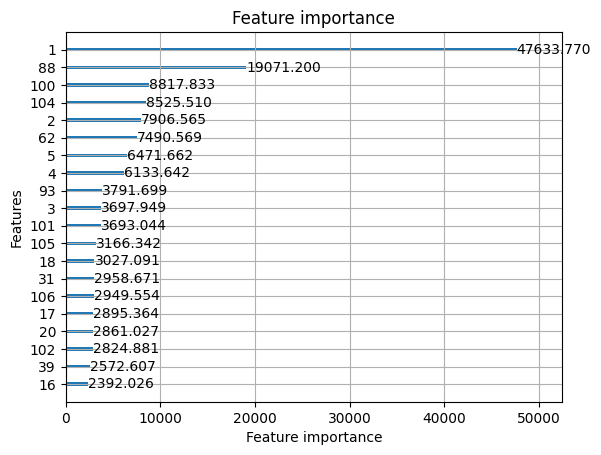

In [43]:
lgb.plot_importance(model, importance_type='gain', max_num_features=20)

In [72]:
selected_lud_feature_ids = [1, 88, 100, 104, 2, 62, 5, 4, 3, 101, 105]

selected_features = lud_and_agent_features_df.iloc[:, selected_lud_feature_ids]

model = lgb.LGBMRegressor()
model.fit(
    selected_features.iloc[train_idx],
    targets[train_idx],
    eval_set=[(selected_features.iloc[test_idx], targets[test_idx])],
    eval_metric='rmse'
)

model.best_score_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1799
[LightGBM] [Info] Number of data points in the train set: 186992, number of used features: 11
[LightGBM] [Info] Start training from score 0.042775


defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('rmse', 0.5662884270406904),
                          ('l2', 0.32068258260021937)])})

# Select English LSA features

In [59]:
english_and_agent_features = np.concatenate([
    np.array(all_english_features), 
    agent_features
], axis=1)

english_and_agent_features_df = pd.DataFrame(english_and_agent_features)

# Convert last 8 columns to categorical, rest to float
for col in english_and_agent_features_df.columns[-8:]:
    english_and_agent_features_df[col] = english_and_agent_features_df[col].astype('category')

for col in english_and_agent_features_df.columns[:-8]:
    english_and_agent_features_df[col] = english_and_agent_features_df[col].astype('float')

In [60]:
gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(
    english_and_agent_features, 
    targets, 
    groups=df['GameRulesetName']))

print(f'Train size: {len(train_idx)}, Test size: {len(test_idx)}')

model = lgb.LGBMRegressor()
model.fit(
    english_and_agent_features_df.iloc[train_idx],
    targets[train_idx],
    eval_set=[(english_and_agent_features_df.iloc[test_idx], targets[test_idx])],
    eval_metric='rmse'
)

Train size: 186992, Test size: 46242
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25529
[LightGBM] [Info] Number of data points in the train set: 186992, number of used features: 108
[LightGBM] [Info] Start training from score 0.042775


LGBMRegressor()

In [61]:
model.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('rmse', 0.5486745551321235),
                          ('l2', 0.30104376744943373)])})

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

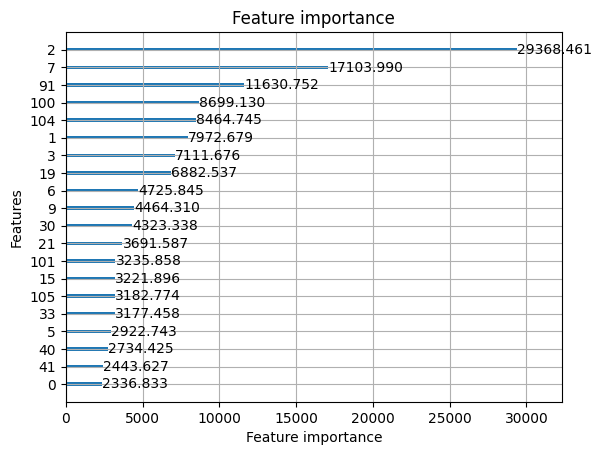

In [62]:
lgb.plot_importance(model, importance_type='gain', max_num_features=20)

In [73]:
selected_english_feature_ids = [2, 7, 91, 100, 104, 1, 3, 19, 6, 9, 30, 21, 101, 15, 105]
# selected_feature_ids = [2, 7, 91, 100, 104, 1, 3]

selected_features = english_and_agent_features_df.iloc[:, selected_english_feature_ids]

model = lgb.LGBMRegressor()
model.fit(
    selected_features.iloc[train_idx],
    targets[train_idx],
    eval_set=[(selected_features.iloc[test_idx], targets[test_idx])],
    eval_metric='rmse'
)

model.best_score_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2818
[LightGBM] [Info] Number of data points in the train set: 186992, number of used features: 15
[LightGBM] [Info] Start training from score 0.042775


defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('rmse', 0.561914649215732),
                          ('l2', 0.3157480730032391)])})

# Save selected rule features

In [82]:
import json

filtered_selected_lud_feature_ids = [
    feature_id 
    for feature_id in selected_lud_feature_ids 
    if feature_id < len(all_lud_features[0])
]
print(filtered_selected_lud_feature_ids)
all_selected_lud_features = np.array(all_lud_features)[:, filtered_selected_lud_feature_ids]

print(all_selected_lud_features.shape, len(all_lud_rules))

lud_rules_to_selected_features = dict(zip(all_lud_rules, all_selected_lud_features.tolist()))

with open('data/lsa/lud_rules_to_selected_features.json', 'w') as output_file:
    json.dump(lud_rules_to_selected_features, output_file, indent=4)

[1, 88, 2, 62, 5, 4, 3]
(233234, 7) 233234


In [83]:
filtered_selected_english_feature_ids = [
    feature_id 
    for feature_id in selected_english_feature_ids 
    if feature_id < len(all_english_features[0])
]
print(filtered_selected_english_feature_ids)
all_selected_english_features = np.array(all_english_features)[:, filtered_selected_english_feature_ids]

print(all_selected_english_features.shape, len(all_english_rules))

english_rules_to_selected_features = dict(zip(all_english_rules, all_selected_english_features.tolist()))

with open('data/lsa/english_rules_to_selected_features.json', 'w') as output_file:
    json.dump(english_rules_to_selected_features, output_file, indent=4)

[2, 7, 91, 1, 3, 19, 6, 9, 30, 21, 15]
(233234, 11) 233234


# Save preprocessing details

In [84]:
import pickle

preprocessor = {
    'lud_vectorizer': lud_vectorizer,
    'lud_lsa': lud_lsa,
    'english_vectorizer': english_vectorizer,
    'english_lsa': english_lsa,
    'selected_lud_feature_ids': filtered_selected_lud_feature_ids,
    'selected_english_feature_ids': filtered_selected_english_feature_ids
}

with open('data/lsa/preprocessor.pkl', 'wb') as output_file:
    pickle.dump(preprocessor, output_file)

# Verify results are reproducible

In [87]:
test_x = lud_vectorizer.transform(df['LudRules'])
test_x = lud_lsa.transform(test_x)
test_x = test_x[:, filtered_selected_lud_feature_ids]

print(test_x.shape)

(233234, 7)


In [90]:
df['LudRules'].iloc[-1]

'(game "Zuz Mel (7x7)" (players 2) (equipment { (board (square 7)) (piece "Marker" Each (or (move Hop Orthogonal (between if:(is Enemy (who at:(between))) (apply (remove (between))) ) (to if:(is Empty (to))) (then (if (can Move (hop (from (last To)) Orthogonal (between if:(and (not (is In (between) (sites ToClear) ) ) (is Enemy (who at:(between))) ) ) (to if:(is Empty (to))) ) ) (moveAgain) ) ) ) (move Slide Orthogonal) ) ) } ) (rules (start { (place "Marker1" (union (expand (sites Bottom) steps:2) (sites {"F4" "G4" "E4"}) ) ) (place "Marker2" (union (expand (sites Top) steps:2) (sites {"A4" "B4" "C4"}) ) ) } ) (play (if (is Prev Mover) (or (move Hop (from (last To)) (between if:(and (not (is In (between) (sites ToClear))) (is Enemy (who at:(between))) ) (apply (remove (between))) ) (to if:(is Empty (to))) (then (if (can Move (hop (from (last To)) (between if:(and (not (is In (between) (sites ToClear) ) ) (is Enemy (who at:(between))) ) ) (to if:(is Empty (to))) ) ) (moveAgain) ) ) ) (

In [91]:
test_x[-1]

array([-0.20662806,  0.00718576,  0.52303899, -0.0043507 , -0.30623913,
       -0.04361554,  0.11885064])

In [92]:
test_x = english_vectorizer.transform(df['EnglishRules'])
test_x = english_lsa.transform(test_x)
test_x = test_x[:, filtered_selected_english_feature_ids]

print(test_x.shape)

(233234, 11)


In [93]:
df['EnglishRules'].iloc[-1]

"7x7 board. 24 pieces per player. Pieces begin in the rows closest to the player, and the three spaces to the right of the central space. Players alternate turns moving a piece orthogonally any distance. A player may capture an opponent's adjacent piece by hopping over it in an orthogonal direction to an empty space immediately on the opposite side of the opponent's piece. Multiple captures are allowed. The player who captures all of the opponent's pieces wins."

In [94]:
test_x[-1]

array([-0.14633185, -0.02455463,  0.05547926, -0.26278004,  0.09510966,
       -0.15982056,  0.05028874,  0.24322932,  0.04584661, -0.00776054,
       -0.10341783])